# import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Func

In [2]:
def nuke_Epa(x):
    if (abs(x) <= 1):
        return 3/4 * (1-x**2)
    else:
        return 0
    
def nuke_Epa_der(x):
    if (abs(x) <= 1):
        return (-3*x)/2
    else:
        return 0
    
def h_estimate_opt(X_pred, x_train, y_train, par_blur, nuke_der):
    def find_borders(x, some_x, par_blur):
        # x - точки диапазона переменной обучающей выборки
        # some_x - точка, значение в которой нужно предсказать
        # par_blur - параметр размытости
        # border_index -  индекс правой границы
        border_index = len(x)-1
        border_value = some_x + 30*par_blur
        for i in range(len(x)):
            if ( x.iloc[i] > border_value ):
                return i
        return border_index
    
    border_index = find_borders(x_train, X_pred, par_blur)
    x_train = x_train[0:border_index]
    y_train = y_train[0:border_index]
    c = 0
    size = len(x_train)
    T = x_train.iloc[-1] - x_train.iloc[0]
    z = T / (size * (par_blur**2))
    for i in range(size):
        c += y_train.iloc[i] * nuke_der((X_pred-x_train.iloc[i])/par_blur)
    return z * c

In [78]:
def u_estimate_opt(X_pred, x_train, y_train, par_blur, nuke_der, T, dt, u):
    def find_borders(x, some_x, par_blur):
        # x - точки диапазона переменной обучающей выборки
        # some_x - точка, значение в которой нужно предсказать
        # par_blur - параметр размытости
        # border_index -  индекс правой границы
        border_index = len(x)-1
        border_value = some_x + 30*par_blur
        for i in range(len(x)):
            if ( x.iloc[i] > border_value ):
                return i
        return border_index
    
    border_index = find_borders(x_train, X_pred, par_blur)
    x_train = x_train[0:border_index]
    y_train = y_train[0:border_index]
    c = 0
    size = len(x_train)
    T = x_train.iloc[-1] - x_train.iloc[0]
    z = T / (size * (par_blur**2))
    j_list = np.arange(0,X_pred+dt,dt)
    for j in j_list:
        for i in range(len(x_train)):
            c += y_train.iloc[i] * ( nuke_der((X_pred-x_train.iloc[i] - j)/par_blur) ) * u(j) * dt
    return z * c

In [80]:
def u_one(x):
    if (x>=0):
        return 1
    else: return 0

def x_want(t):
    if (t>=0):
        return 2
    else: return 0

# Pic

In [4]:
def h_pic(data, data_sample):
    fig = plt.figure(figsize =(10, 5))
    ax = plt.axes()
    plt.title('Восстановление весовой функции')
    ax.plot(data['t'], data['obj1_one'],c='magenta', label='$k$')
    ax.plot(data['t'],data['obj1_one_derivative'],'--', c='magenta', label='$h$')

    ax.plot(data_sample['t'],data_sample['h_estimate'], c='red', label='$\hat{h}$')

    ax.scatter(data_sample['t'], data_sample['obj1_one'],c='#D752FF', s=10)
    ax.scatter(data_sample['t'], data_sample['obj1_one_derivative'],c='#D752FF', s=10)

    plt.legend()
    plt.grid()
    plt.show()

def w_pic(data, data_sample):
    fig = plt.figure(figsize =(10, 5))
    ax = plt.axes()
    plt.title('Обратная весовая функция')
    ax.plot(data['t'], data['obj1_one'],c='magenta', label='$k$')
    ax.plot(data['t'],data['obj1_one_derivative'],'--', c='magenta', label='$h$')

    ax.plot(data_sample['t'],data_sample['h_estimate'], c='red', label='$\hat{h}$')

    ax.scatter(data_sample['t'], data_sample['obj1_one'],c='#D752FF', s=10)
    ax.scatter(data_sample['t'], data_sample['obj1_one_derivative'],c='#D752FF', s=10)

    ax.plot(data_sample['t'],data_sample['w_estimate'], c='blue', label='$\hat{w}$')

    ax.set_xlim(0,2)
    ax.set_ylim(-3000,3000)
    plt.legend()
    plt.grid()
    plt.show()

# work

In [61]:
T = 12.5
period = 5
dispersion = 0.01
random_state = 10

In [6]:
def normal_DE(y,x, k0, k1, k2, u):
    z = - k0*y[0] - k1*y[1] - k2*y[2]  + u(x)
    return [ y[1], y[2], z ]

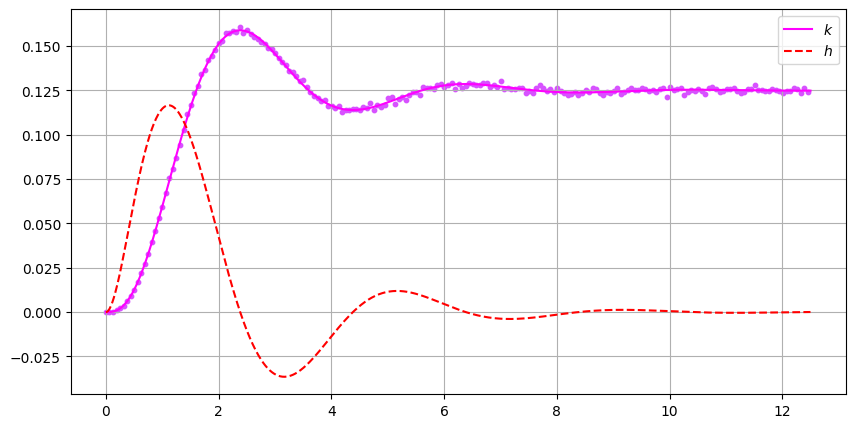

In [62]:
data = pd.DataFrame()
x = np.linspace(0, T, 1000)
data['t'] = x
y0 = [ 0, 0, 0 ]

# k0 , k1, k2 = [ 0.5, 1 , 1.5 ]
k0 , k1, k2 = [ 8, 6 , 4 ]
#k0 , k1, k2 = [ 0.9, 2 , 3 ]
sol1 = odeint(normal_DE, y0, x, args=(k0, k1, k2, u_one))

data['obj1_one'] = sol1[:,0]
data['obj1_one_derivative'] = sol1[:,1]

size = np.shape(data['t'][::period])[0]
data_sample = pd.DataFrame()
# делаем выборку с заданным периодом из всех точек что есть
#добавляем шум к данным
np.random.seed(random_state)
data_sample['t'] = data['t'][::period]
data_sample['obj1_one'] = data['obj1_one'][::period] + dispersion * np.random.normal(0,1,size)*data['obj1_one'][::period] 
data_sample['obj1_one_derivative'] = data['obj1_one_derivative'][::period] + dispersion * np.random.normal(0,1,size)*data['obj1_one_derivative'][::period] 
# data_sample['obj1_one'] = data['obj1_one'][::period] +  np.random.normal(0,dispersion,size)
# data_sample['obj1_one_derivative'] = data['obj1_one_derivative'][::period] + np.random.normal(0,dispersion,size)
# data_sample['obj1_one'] = data['obj1_one'][::period]
# data_sample['obj1_one_derivative'] = data['obj1_one_derivative'][::period]

fig = plt.figure(figsize =(10, 5))
ax = plt.axes()
# plt.title('Восстановление весовой функции')
ax.plot(data['t'], data['obj1_one'],c='magenta', label='$k$')
# ax.plot([0,T],[2.1,2.1])
# ax.plot([0,T],[1.9,1.9])
ax.plot(data['t'],data['obj1_one_derivative'],'--', c='red', label='$h$')

ax.scatter(data_sample['t'], data_sample['obj1_one'],c='#D752FF', s=10)
# ax.scatter(data_sample['t'], data_sample['obj1_one_derivative'],c='#D752FF', s=10)

plt.legend()
plt.grid()
plt.show()

100%|██████████| 200/200 [00:00<00:00, 239.90it/s]


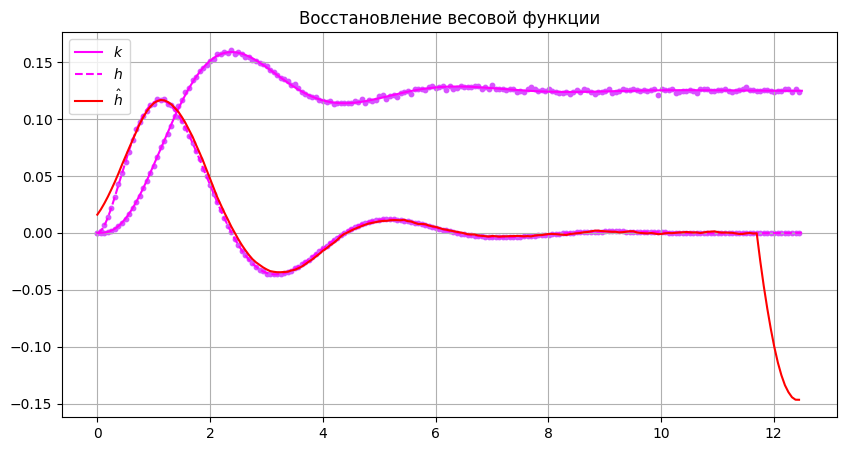

In [71]:
h = []
blur = 0.69
for i in tqdm(range(size)):
    # if i<40: blur = 0.88
    # else: blur = 1.5
    h.append( h_estimate_opt(data_sample['t'].iloc[i], data_sample['t'], data_sample['obj1_one'], blur, nuke_Epa_der) )

data_sample['h_estimate'] = h
h_pic(data,data_sample)


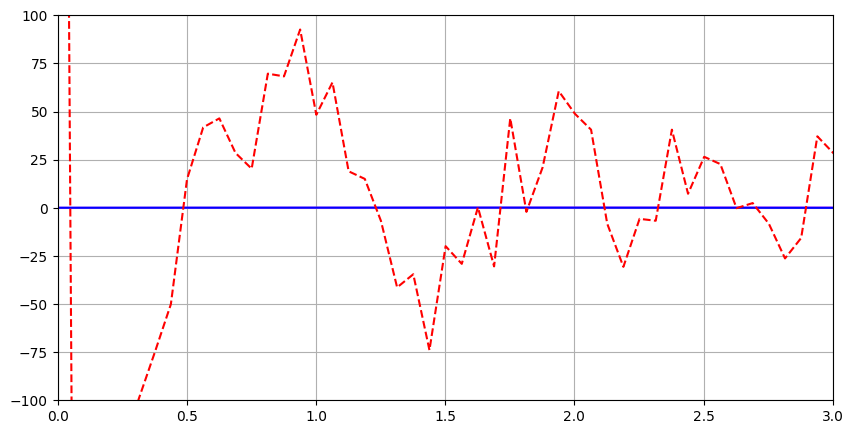

In [79]:
dt = data_sample['t'].iloc[2] - data_sample['t'].iloc[1]
size = len(data_sample['h_estimate'])
w = np.zeros(size)
w[0] = 1 / (data_sample['h_estimate'].iloc[0] * dt)
for i in range(1,size):
    #print(f'{i=}')
    temp_w = np.array([])
    if i == 1:
        temp_w = np.append(temp_w,data_sample['h_estimate'].iloc[1] * w[0])
    else:
        for j in range(i):
            temp_w = np.append(temp_w,data_sample['h_estimate'].iloc[i-j] * w[j])
    g = np.sum(temp_w)
    eee = (1 - np.sum(temp_w) * dt) / (data_sample['h_estimate'].iloc[0] * dt)
    w[i] = (1 - np.sum(temp_w) * dt) / (data_sample['h_estimate'].iloc[0] * dt)

data_sample['w_estimate'] = w
fig = plt.figure(figsize =(10, 5))
ax = plt.axes()

ax.plot(data_sample['t'], data_sample['obj1_one'],c='#D752FF')
ax.plot(data_sample['t'], data_sample['h_estimate'],c='blue')
ax.plot(data_sample['t'], data_sample['w_estimate'], '--', c='red')

ax.set_xlim(0,3)
# ax.set_ylim(-15,40)
ax.set_ylim(-100,100)
#plt.legend()
plt.grid()
plt.show()

In [115]:
data_sample['t'].iloc[2]-data_sample['t'].iloc[1]

0.06256256256256257

100%|██████████| 80/80 [00:05<00:00, 14.62it/s]


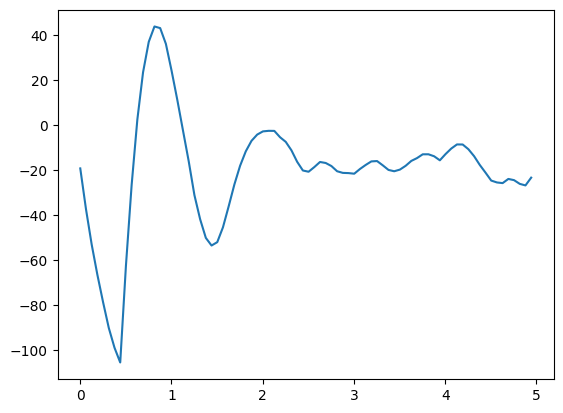

In [132]:
u_control = []
blur1 = 0.5
# for i in tqdm(range(size)):
for i in tqdm(range(80)):
    # if (data_sample['t'].iloc[i] < 1):
    #     blur1 = 0.5
    # elif (data_sample['t'].iloc[i] < 4):
    #     blur1 = 0.8
    #     #blur2 = 0.5
    # else:
    #     blur1 = 0.46
    #     #blur2 = 0.7
    u_control.append( u_estimate_opt(data_sample['t'].iloc[i], data_sample['t'], data_sample['w_estimate'], blur1, nuke_Epa_der,T,dt,x_want) )

u_control = np.array(u_control)

#data_sample['u_control'] = u_control

plt.plot(data_sample['t'][:80], u_control)
plt.show()


100%|██████████| 200/200 [00:37<00:00,  5.34it/s]


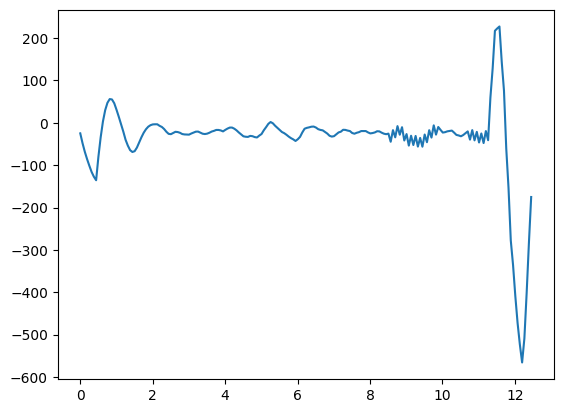

In [ ]:
u_control = []
blur1 = 5
for i in tqdm(range(size)):
    # if (data_sample['t'].iloc[i] < 1):
    #     blur1 = 0.5
    # elif (data_sample['t'].iloc[i] < 4):
    #     blur1 = 0.8
    #     #blur2 = 0.5
    # else:
    #     blur1 = 0.46
    #     #blur2 = 0.7
    u_control.append( u_estimate_opt(data_sample['t'].iloc[i], data_sample['t'], data_sample['w_estimate'], blur1, nuke_Epa_der,T,dt,x_want) )

u_control = np.array(u_control)

data_sample['u_control'] = u_control

plt.plot(data_sample['t'], data_sample['u_control'])
plt.show()

In [82]:
def Nuke_regression(X_pred, x_train, y_train, par_blur, nuke):
    c = 0
    z = 0
    # print(f'{len(x_train)=}')
    # print(f'{par_blur=}')
    for i in range(len(x_train)):
        c += y_train[i]* ( nuke( (X_pred-x_train[i]) / par_blur) )
        z += ( nuke((X_pred-x_train[i])/par_blur) )
    return c/z

In [99]:
def f_u_control(x):
    print(f'{x=}')
    return u_estimate_opt(x, data_sample['t'], data_sample['w_estimate'], blur1, nuke_Epa_der,T,dt,x_want)

In [133]:
x = np.linspace(0, 5, 80)
sol_control = odeint(normal_DE, y0, x, args=(k0, k1, k2, f_u_control))

data_sample['obj1_control'] = sol_control[:,0]


x=0.0
x=4.883029913645079e-06
x=4.883029913645079e-06
x=7.54945692490724e-08
x=7.54945692490724e-08
x=9.386831666518324e-09
x=9.386831666518324e-09
x=0.0
x=9.386831666518324e-10
x=9.386831666518324e-10
x=1.8773663333036647e-09
x=1.8773663333036647e-09
x=2.816049499955497e-09
x=2.816049499955497e-09
x=3.7547326666073295e-09
x=3.7547326666073295e-09
x=4.693415833259162e-09
x=4.693415833259162e-09
x=6.570782166562827e-09
x=8.448148499866491e-09
x=1.0325514833170156e-08
x=2.9099178166206802e-08
x=4.787284149924345e-08
x=6.66465048322801e-08
x=2.543831381626466e-07
x=4.421197714930131e-07
x=6.298564048233796e-07
x=8.175930381537461e-07
x=2.694959371457411e-06
x=4.5723257047610755e-06
x=6.449692038064741e-06
x=8.327058371368406e-06
x=2.7100721704405054e-05
x=2.7100721704405054e-05
x=4.5874385037441704e-05
x=4.5874385037441704e-05
x=6.464804837047835e-05
x=6.464804837047835e-05
x=8.3421711703515e-05
x=8.3421711703515e-05
x=0.0002711583450338815
x=0.0002711583450338815
x=0.00045889497836424796

ValueError: Length of values (80) does not match length of index (200)

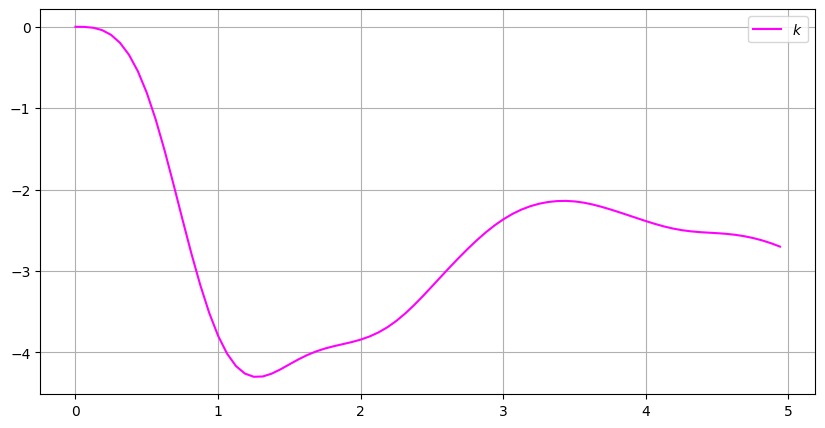

In [134]:
fig = plt.figure(figsize =(10, 5))
ax = plt.axes()
# plt.title('Восстановление весовой функции')
ax.plot(data_sample['t'][:80], sol_control[:,0],c='magenta', label='$k$')


plt.legend()
plt.grid()
plt.show()